In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from pyckmeans import MultiCKMeans

In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [3]:
cluster_name = "Cluster-2"

In [4]:
tpm = pd.read_csv(f"../../../../data/expression/processed/response-subtype-train/V4/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-TPM-TRAIN-2023-08-10-V4.tsv", 
                  sep='\t', 
                  index_col=0)

minmax = pd.read_csv(f"../../../../data/expression/processed/response-subtype-train/V4/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-TPM-MinMaxNorm-TRAIN-2023-08-10-V4.tsv", 
                     sep='\t', 
                     index_col=0)

labels = pd.read_csv(f"../../../../data/expression/processed/response-subtype-train/V4/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-LABEL-TRAIN-2023-08-10-V4.tsv",
                     sep='\t', 
                     index_col=0, 
                     header=None)

ratios = pd.read_csv(f"../../../../data/expression/processed/response-subtype-train/V4/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-R2.taux",
                     sep='\t',
                     header=None, 
                     comment='#')

ratios = ratios[ratios[2].abs() > 4.5]

ratios.sort_values(2)

,0,1,2
565,ENSG00000121335,ENSG00000188916,4.50169
1051,ENSG00000255987,ENSG00000165244,4.50262
1065,ENSG00000183813,ENSG00000257607,4.50335
986,ENSG00000248544,ENSG00000231340,4.50366
502,ENSG00000089012,ENSG00000182578,4.50385
...,...,...,...
165,ENSG00000138378,ENSG00000118496,7.21602
189,ENSG00000089012,ENSG00000144028,7.70382
101,ENSG00000124256,ENSG00000120696,7.72252
878,ENSG00000241106,ENSG00000120696,8.16412


In [5]:
ratios["ratio"] = ratios[0] + ":::" + ratios[1]

In [6]:
rvalues = pd.DataFrame(index=ratios["ratio"], columns=minmax.columns, dtype=np.float64)

In [7]:
for i, row in ratios.iterrows():
    rvalues.loc[row.ratio] = minmax.loc[row[0], :] / minmax.loc[row[1], :]

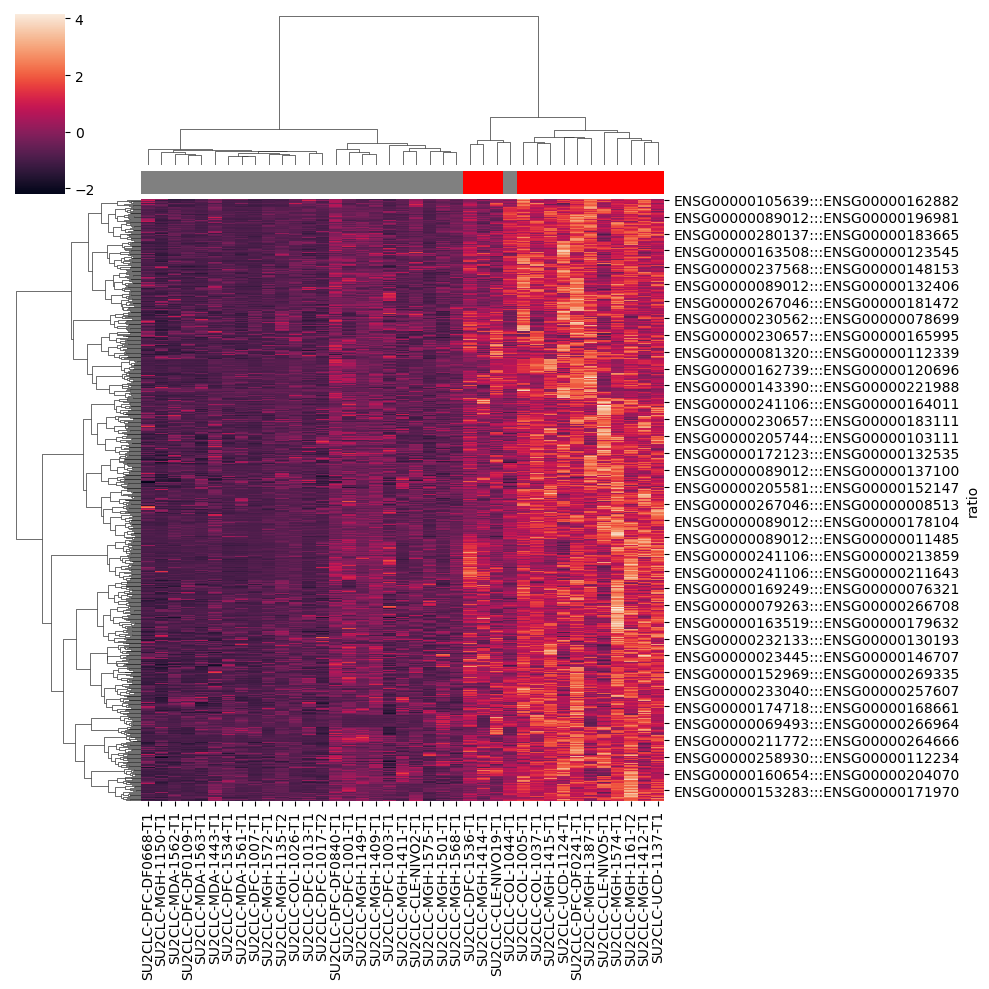

In [8]:
sns.clustermap(rvalues, 
               method="ward", 
               z_score=0, 
               col_colors=["red" if x == 1 else "gray" for x in labels.values])

In [9]:
def search_sample_clusters(exp):
    mckm = MultiCKMeans(k=range(2, 8), n_rep=100, p_samp=0.8, p_feat= 0.8)
    mckm.fit(exp)
    mckm_res = mckm.predict(exp, linkage_type="ward")

    # plot clustering metrics against k
    # BIC, DB: lower is better
    # SIL, CH: higher is better
    mckm_res.plot_metrics(figsize=(10,5))
    
    return mckm_res
    
def assign_sample_clusters(mckm_res, nclusters, prefix=""):
    if nclusters == 1:
        return pd.DataFrame(index=mckm_res.names, columns=["cluster"], data=f"{prefix}0")
    
    study_clusters = pd.DataFrame()

    mckm_res_k = mckm_res.ckmeans_results[nclusters - 2]

    # plot consensus matrix and consensus clustering
    fig = mckm_res_k.plot(figsize=(7,7))
    plt.savefig("ratio-clusters.svg", format='svg')

    for sample, cluster in zip(mckm_res.names, mckm_res_k.cl):
        study_clusters.loc[sample, "cluster"] = f"{prefix}{cluster}"
        
    return study_clusters

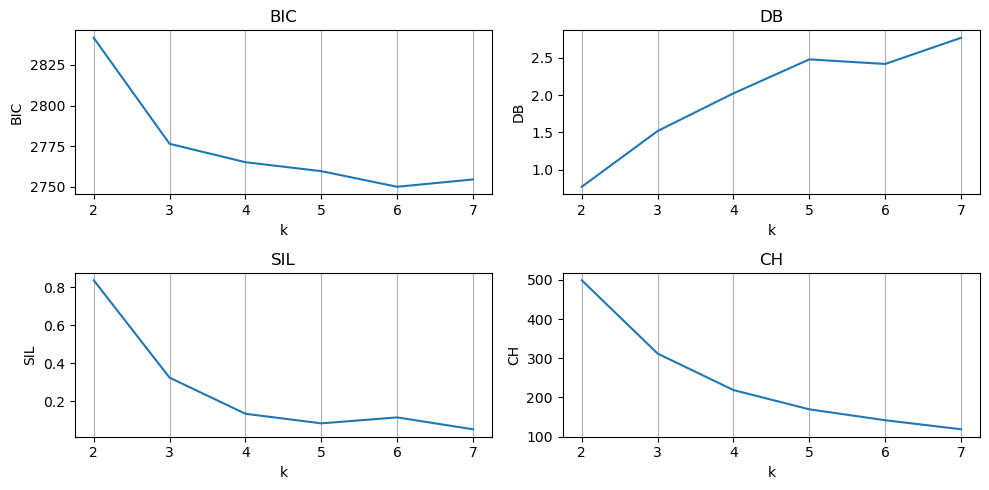

In [10]:
mckm_res = search_sample_clusters(rvalues)

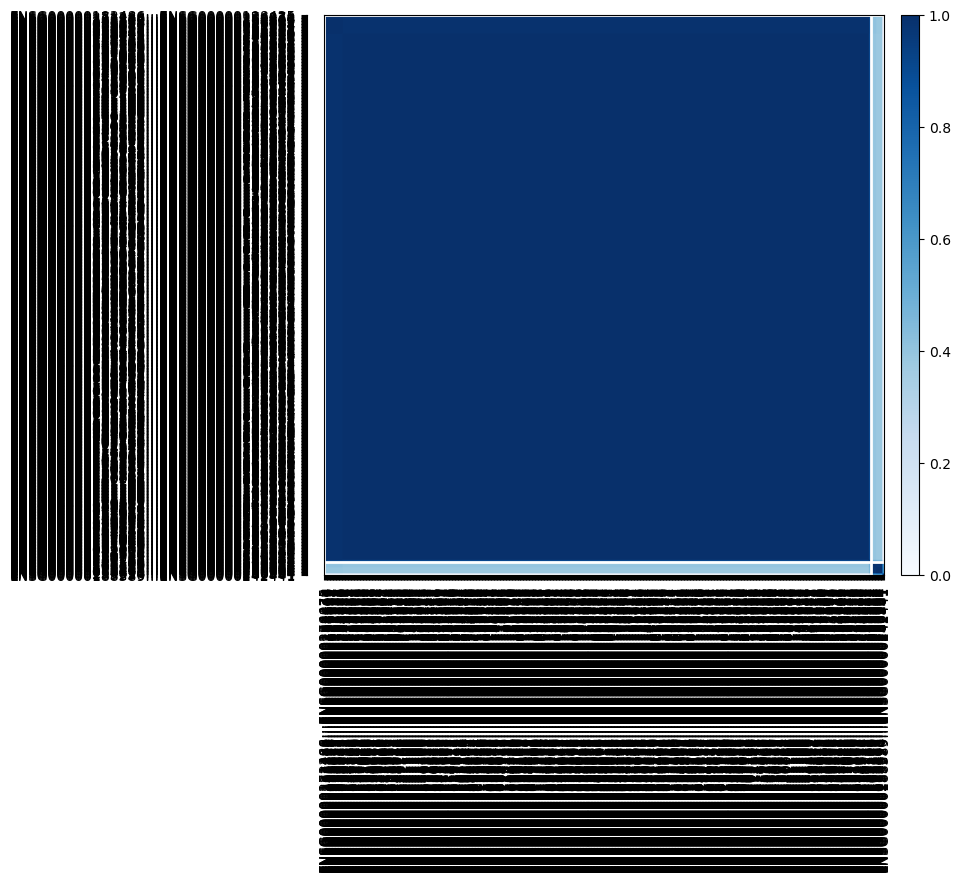

In [11]:
ratio_clusters = assign_sample_clusters(mckm_res, 2, prefix="ratio-cluster-")

In [12]:
ratio_clusters.to_csv(f"../../../../data/ratios/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-ratios.tsv",
                      sep='\t')

In [13]:
cluster_gs = []

for cluster, rows in ratio_clusters.groupby("cluster"):

    # Changed to 100 genes from 50 -- Need to finish exploring this
    tmp = ratios.reindex(ratios[ratios["ratio"].isin(rows.index.values)][2].abs().sort_values().tail(50).index.values)
        
    for x in tmp.ratio.values:
        
        numerator, denominator = x.split(":::")
        
        cluster_gs.append((cluster,  x, "up", numerator))
        cluster_gs.append((cluster, x, "down", denominator))
        
cluster_gs = pd.DataFrame(cluster_gs, columns=["gs", "ratio", "direction", "gene"])
cluster_gs.to_csv(f"../../../../data/gs/IO-Atlas-NSCLC-NSCLC-Response-{cluster_name}-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-gene-sets.tsv",
                  sep='\t')

In [14]:
cluster_gs.groupby("gs").count()

,ratio,direction,gene
gs,,,
ratio-cluster-0,100,100,100
ratio-cluster-1,34,34,34
